# Higher Level Analysis of Project01

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import astropy
from astropy.table import table
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

from dlnpyutils import coords

import prometheus

 The code from the previous part has been run, and we are picking up from this image and related table:

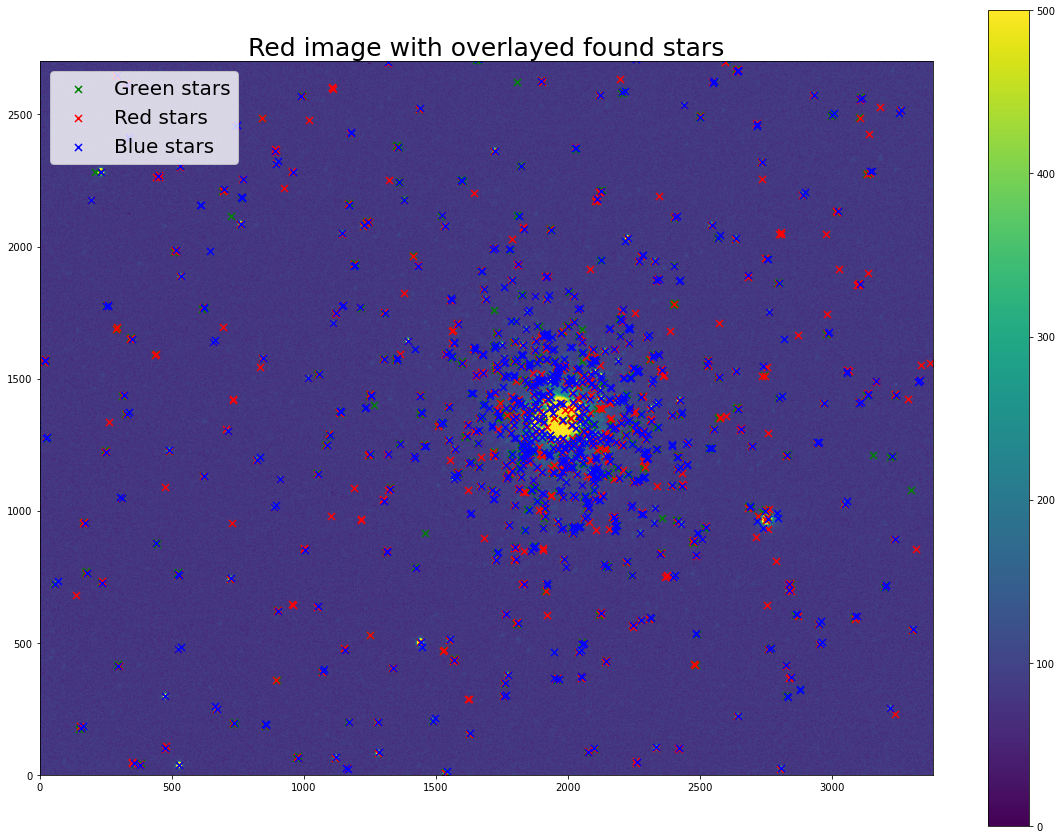

In [11]:
plt.figure(figsize=(20,15))

# notice, most of the green get hidden behind the red.
plt.scatter(points_G[0], points_G[1], marker='x', c='g', s=50, label='Green stars')
plt.scatter(points_R[0], points_R[1], marker='x', c='r', s=50, label='Red stars')
plt.scatter(points_B[0], points_B[1], marker='x', c='b', s=50, label='Blue stars')

plt.imshow(imR_4,vmin=0, vmax=500,origin='lower')
plt.legend(fontsize=20)
plt.colorbar()

plt.title('Red image with overlayed found stars', fontsize=25)
plt.show()

In [12]:
all_mags

xc,yc,MAG_3R,MAG_3G,MAG_3B
float64,float64,float64,object,object
1534.88184155581,5.308114044504009,11.310918881264282,12.788883832514717,15.348129977038509
2803.8535215351258,23.67342501686403,12.48617014586098,12.464157683009487,13.034722755982473
378.82302224909995,37.80761478872387,15.16248011852059,14.747505613574186,16.337928201632447
354.0310261354198,44.19222208123233,16.000378658025998,15.399831581097672,16.929509892946164
526.1449321249161,37.47332400616324,10.77288556652507,10.530390355384702,10.827484346001611
2257.5412384315127,45.39874482178698,14.32906098300408,14.61407812802647,15.76284489268813
977.5861745974842,65.15160023410772,15.130628721301132,14.890525120838024,15.338526555971274
1119.2421790071853,64.92989531642843,12.122340232763051,12.376383190596066,13.075195551802041
2074.3358703167696,85.66470906055179,14.770123165406021,14.536180599177854,15.373902022271967


In [8]:
def quick_xmatch(set_Data, new_Data, max_rad = 20):
    max_rad = max_rad**2
    trans_list = []
    dis_list = []
    for b in zip(new_Data[0], new_Data[1]):
        min_dis = (10e10, None)
        counter = 0
        for r in zip(set_Data[0], set_Data[1]):
            dist = (b[0]-r[0])**2 + (b[1]-r[1])**2
            if dist < min_dis[0]: min_dis = (dist, counter)
            counter += 1
        dis_list.append(min_dis[0])
        if min_dis[1] in trans_list:
            index = trans_list.index(min_dis[1])
            if min_dis[0] < dis_list[index]:
                trans_list.append(min_dis[1])
                trans_list[index] = None
            else:
                trans_list.append(None)
        else:
            trans_list.append(min_dis[1])
        if min_dis[0] > max_rad: trans_list[-1] = None
    return trans_list

In [9]:
def mag_match(match_list, give_target, get_target, get_dat, comped = points_R):
    count = -1
    for match in match_list:
        count += 1
        if match == None: continue
        row = all_mags[(all_mags['xc'] == comped[0, match]) & (all_mags['yc'] == comped[1, match])]
        row[give_target] = get_dat[count][get_target]
        all_mags[(all_mags['xc'] == comped[0, match]) & (all_mags['yc'] == comped[1, match])] = row
        all_mags[(all_mags['xc'] == comped[0, match]) & (all_mags['yc'] == comped[1, match])]

For the rest of the analysis, these are the steps:
<ol>
    <li>Grabbing data from SDSS.</li>
    <li>Using that data to callibrate our data.</li>
    <li>Checking the magnitudes all look relatively good.</li>
    <li>Plotting some important CMDs.</li>
    <li>Attempt isochrone fitting.</li>
</ol>

## 1. Grabbing data from SDSS

In [16]:
from dl import queryClient as qc
sdss = qc.query(sql='select ra, dec, g, r from sdss_dr16.photoplate where q3c_radial_query(ra,dec,322.493,12.167,0.3)',fmt='table')

## 2. Use SDSS data to callibrate magnitudes

In [17]:
# processing data and doing cross matching
sdss_pix = wR_4.wcs_world2pix(np.array([sdss['ra'], sdss['dec']]).T, 0).T

trans_list_sdss_R = quick_xmatch(points_R, sdss_pix)
trans_list_sdss_G = quick_xmatch(points_R, sdss_pix)
trans_list_sdss_B = quick_xmatch(points_R, sdss_pix)

all_mags['sdss_R'] = None
all_mags['sdss_G'] = None
all_mags['sdss_B'] = None

mag_match(trans_list_sdss_R, 'sdss_R', 'r', sdss)
mag_match(trans_list_sdss_G, 'sdss_B', 'g', sdss)
# mag_match(trans_list_sdss_B, 'sdss_B', 'u', sdss)

In [18]:
# Calculating mean offset for all the matches
reds = all_mags[all_mags['sdss_R'] != None]
red_offset = np.mean(reds['sdss_R'] - reds['MAG_3R'])
all_mags['MAG_3R'] += red_offset

reds = all_mags[all_mags['sdss_B'] != None]
red_offset = np.mean(reds['MAG_3B'] - reds['sdss_B'])
all_mags['MAG_3B'] += red_offset

## 3. Checking that the magnitudes all look okay
This was to check for both extreme outliers and for matching data. At one point I had imported red onto the green data and there was a one-to-one correlation. This step caught that.

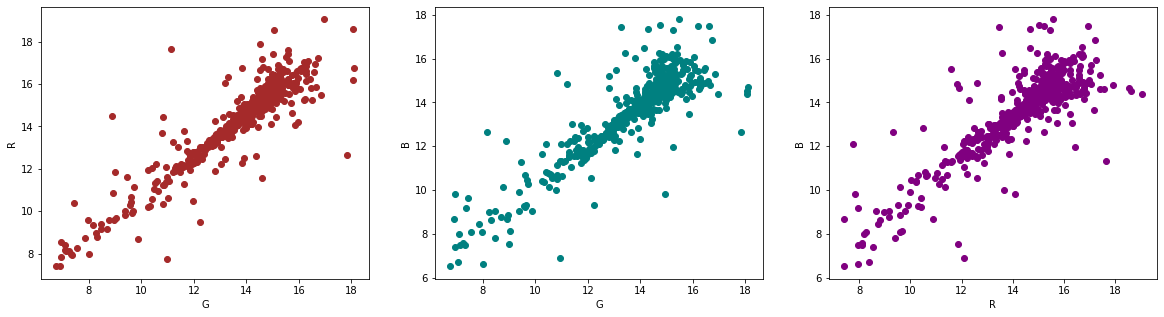

In [19]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.scatter(all_mags['MAG_3G'], all_mags['MAG_3R'], color='brown')
plt.xlabel('G')
plt.ylabel('R')
plt.subplot(1,3,2)
plt.scatter(all_mags['MAG_3G'], all_mags['MAG_3B'], color='teal')
plt.xlabel('G')
plt.ylabel('B')
plt.subplot(1,3,3)
plt.scatter(all_mags['MAG_3R'], all_mags['MAG_3B'], color='purple')
plt.xlabel('R')
plt.ylabel('B')
plt.show()

In [20]:
all_mags

xc,yc,MAG_3R,MAG_3G,MAG_3B,sdss_R,sdss_G,sdss_B
float64,float64,float64,object,object,object,object,object
1534.88184155581,5.308114044504009,11.87927548369589,12.788883832514717,14.638388404506147,None,None,None
2803.8535215351258,23.67342501686403,13.054526748292588,12.464157683009487,12.324981183450111,None,None,None
378.82302224909995,37.80761478872387,15.730836720952198,14.747505613574186,15.628186629100085,None,None,None
354.0310261354198,44.19222208123233,16.568735260457604,15.399831581097672,16.219768320413802,None,None,None
526.1449321249161,37.47332400616324,11.341242168956677,10.530390355384702,10.11774277346925,None,None,None
2257.5412384315127,45.39874482178698,14.897417585435688,14.61407812802647,15.053103320155769,None,None,None
977.5861745974842,65.15160023410772,15.69898532373274,14.890525120838024,14.628784983438912,15.573146,None,15.955643
1119.2421790071853,64.92989531642843,12.69069683519466,12.376383190596066,12.36545397926968,None,None,None
2074.3358703167696,85.66470906055179,15.33847976783763,14.536180599177854,14.664160449739605,15.258993,None,15.861561


## 4. Plotting CMDs

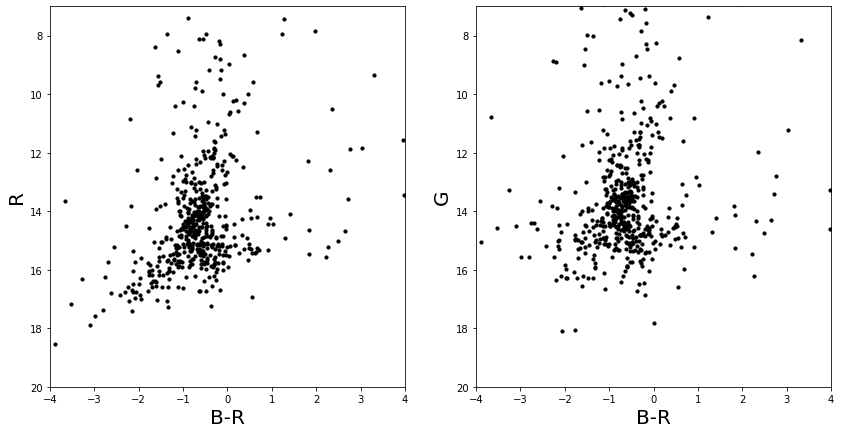

In [25]:
plt.figure(figsize=(14, 7))
plt.subplot(1,2,1)
plt.scatter(all_mags['MAG_3B'] - all_mags['MAG_3R'],
            all_mags['MAG_3R']
            , s = 10, color='black')
plt.ylim(20,7)
plt.xlim(-4, 4)
plt.xlabel('B-R', fontsize=20)
plt.ylabel('R', fontsize=20)

plt.subplot(1,2,2)
plt.scatter(all_mags['MAG_3B'] - all_mags['MAG_3R'],
            all_mags['MAG_3G']
            , s = 10, color='black')
plt.ylim(20,7)
plt.xlim(-4, 4)
plt.xlabel('B-R', fontsize=20)
plt.ylabel('G', fontsize=20)
plt.show()

## Attempting isochrone fitting
I say "attempting" because the data we got out doesn't look all too characterisic of the whole isochrone. You can possibly see someof the horizontal branch, but that's about it. Thus, there isn't gonna be too much time spent on making them match up.

From the wikipedia entery: https://en.wikipedia.org/wiki/Messier_15 <br>

Metallicity: -2.37 dex <br>
age: 12 Gyr

So, the isochrones grabbed were:
<ul>
    <li>12 Gyr, -1.8 metalicity</li>
    <li>12 Gyr, -2.0 metalicity</li>
    <li>12 Gyr, -2.2 metalicity</li>
</ul>

In [26]:
iso = table.Table.read('isochrones/isochrone_12_-1.8.dat', format='ascii')
iso.rename_columns(['col1','col2','col3','col4','col5','col6','col7','col8','col9','col10','col11','col12','col13','col14',
                    'col15','col16','col17','col18','col19','col20','col21','col22','col23','col24','col25','col26','col27',
                    'col28','col29','col30','col31','col32','col33'], 
                   ['Zini', 'MH', 'logAge', 'Mini', 'int_IMF', 'Mass', 'logL', 'logTe', 'logg', 'label', 'McoreTP', 'C_O', 
                    'period0', 'period1', 'period2', 'period3', 'period4', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn', 
                    'Xo', 'Cexcess', 'Z', 'mbolmag', 'umag', 'gmag', 'rmag', 'imag', 'zmag'])

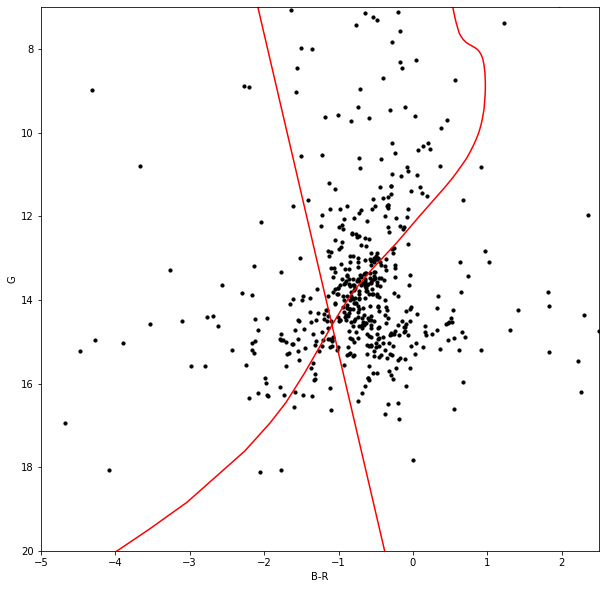

In [27]:
plt.figure(figsize=(10,10))
plt.scatter(all_mags['MAG_3B'] - all_mags['MAG_3R'],
            all_mags['MAG_3G']
            , s = 10, color='black')
plt.plot(iso['rmag']-iso['umag']+2, iso['gmag']+4.5, color='red')
plt.ylim(20,7)
plt.xlim(-5, 2.5)
plt.xlabel('B-R')
plt.ylabel('G')
plt.show()

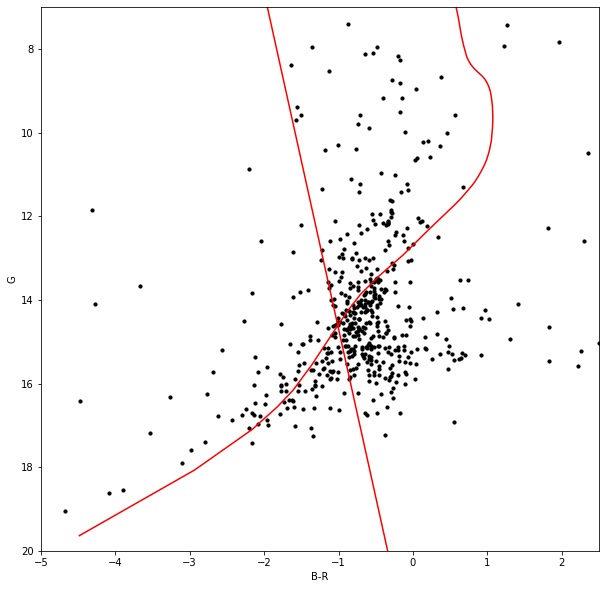

In [29]:
# this one doesn't look all too horrible.
plt.figure(figsize=(10,10))
plt.scatter(all_mags['MAG_3B'] - all_mags['MAG_3R'],
            all_mags['MAG_3R']
            , s = 10, color='black')
plt.plot(iso['rmag']-iso['umag']+2.1, iso['rmag']+5.5, color='red')
plt.ylim(20,7)
plt.xlim(-5, 2.5)
plt.xlabel('B-R')
plt.ylabel('G')
plt.show()